# Librairies

In [1]:
import os
from tqdm import tqdm
from openclassrooms.p6 import *

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras import Input

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import set_config

# Config

In [2]:
STORAGE_PATH = "../data"
FILE_NAME = "data.csv"
set_config(display="diagram")

# Data

In [6]:
data = pd.read_csv(os.path.join(STORAGE_PATH, FILE_NAME))

In [4]:
images = np.array([])
for img_id in tqdm(data.uniq_id):
    
    img_path = os.path.join(STORAGE_PATH, 'Images', img_id + '.jpg')
    img = np.array([img_to_array(load_img(img_path, target_size=(224, 224)))])
    img = preprocess_input(img)
    
    if not images.size:
        images = img
    else:
        images = np.concatenate([images, img], axis=0)

 64%|██████▍   | 677/1050 [01:22<01:18,  4.74it/s]/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2850: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
100%|██████████| 1050/1050 [02:58<00:00,  5.88it/s]


In [12]:
pretrain_model = VGG16(input_tensor=Input(shape=(224, 224, 3)))
model = Model(inputs=pretrain_model.inputs, outputs=pretrain_model.layers[-2].output)

553476096/553467096 [==============================] - 3s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
#features = [model.predict(np.array([img]))[0] for img in tqdm(images)]
#X = pd.DataFrame(features)
#X.to_csv(os.path.join(STORAGE_PATH, 'features_vgg16.csv'), index=False)
X = pd.read_csv(os.path.join(STORAGE_PATH, 'features_vgg16.csv'))

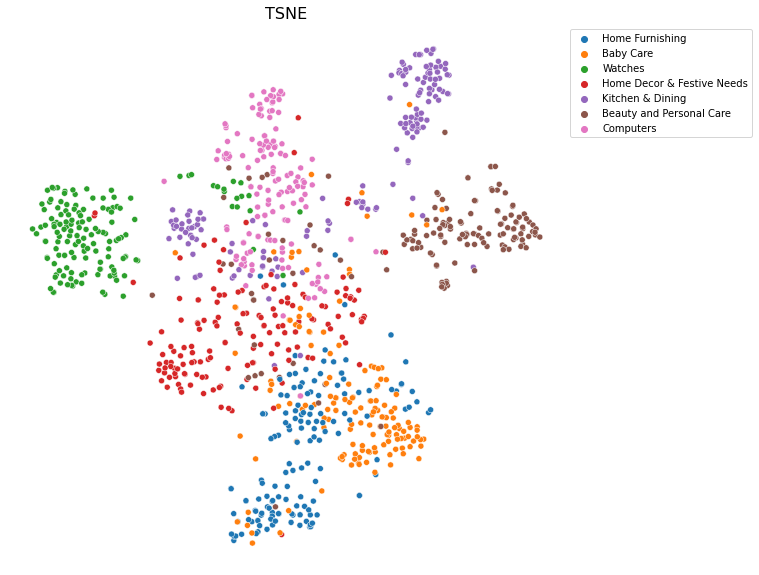

In [7]:
y = data.category_0

plt.figure(figsize=(10, 10))
plot_TSNE(X, y, axis='off')adjusted_rand_score

# Classification

## Supervised approach

In [12]:
y = data.category_0
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [3]:
pipe = Pipeline(steps=[
    ('PCA', CustomPCA(ratio=None)),
    ('classifier', RandomForestClassifier(random_state=0))
])

param_grid = {
    "PCA__ratio": [None, 0.95, 0.99],
}

display(pipe)

Pipeline(steps=[('PCA', CustomPCA(ratio=None)),
                ('classifier', RandomForestClassifier(random_state=0))])

In [14]:
results = pd.DataFrame()

for parameters in tqdm(ParameterGrid(param_grid)):
    
    pipe = pipe.set_params(**parameters)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    score = accuracy_score(y_test, y_pred)
    results = results.append({'score': score, 'parameters': parameters} , ignore_index=True)

100%|██████████| 3/3 [00:10<00:00,  3.34s/it]


In [15]:
best_results_parameters = results.loc[results.score == results.score.max(), 'parameters'].iloc[0]
results.loc[results.score == results.score.max()]

,parameters,score
0,{'PCA__ratio': None},0.836502


In [16]:
pipe = pipe.set_params(**best_results_parameters)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

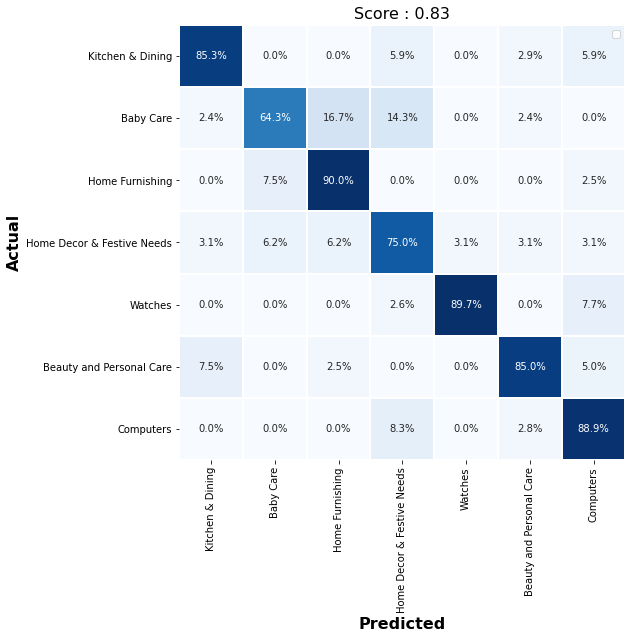

In [17]:
cm = ConfusionMatrix(y_test, y_pred, accuracy_score)
print(cm)

## Unsupervized approach

In [7]:
kmeans = KMeans(n_clusters=data.category_0.nunique(), random_state=0)
pipe = Pipeline(steps=[
    ('PCA', CustomPCA(ratio=None)),
    ('clustering', CustomClustering(kmeans))
])

param_grid = {
    "PCA__ratio": [None, 0.95, 0.99],
}

display(pipe)

Pipeline(steps=[('PCA', CustomPCA(ratio=None)),
                ('clustering',
                 CustomClustering(model=KMeans(n_clusters=7, random_state=0)))])

In [36]:
results = pd.DataFrame()

for parameters in tqdm(ParameterGrid(param_grid)):
    
    pipe = pipe.set_params(**parameters)
    pipe.fit(X, y)
    y_pred = pipe.predict(X)

    score = adjusted_rand_score(y, y_pred)
    results = results.append({'score': score, 'parameters': parameters} , ignore_index=True)

100%|██████████| 3/3 [00:20<00:00,  6.95s/it]


In [37]:
best_results_parameters = results.loc[results.score == results.score.max(), 'parameters'].iloc[0]
results.loc[results.score == results.score.max()]

,parameters,score
2,{'PCA__ratio': 0.99},0.4743


In [39]:
pipe = pipe.set_params(**best_results_parameters)
pipe.fit(X, y)
y_pred = pipe.predict(X)

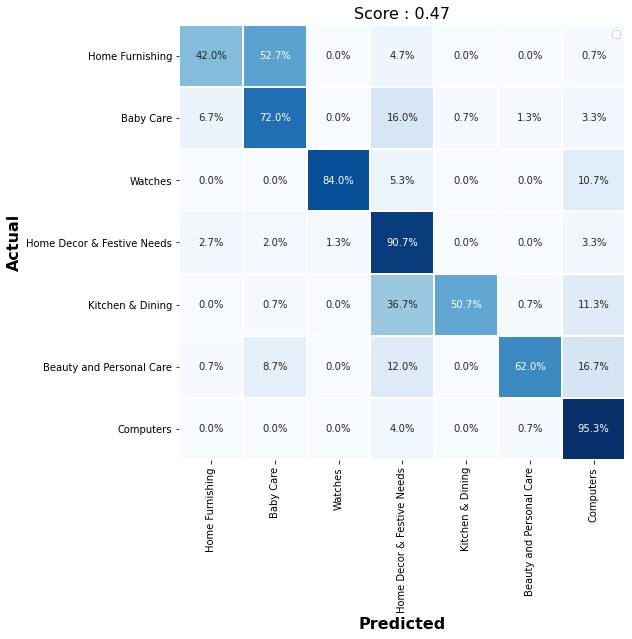

In [40]:
cm = ConfusionMatrix(pd.Series(y), y_pred, adjusted_rand_score)
print(cm)